# Example Notebook

In this notebook we demonstrate CompFS on the Syn1 experiment from the paper. This can be used on custom data if it is written as numpy arrays.

In [39]:
import numpy as np
import torch
import torch.nn as nn
import random
np.random.seed(42)
random.seed(42)
# Set and print device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Import required files from CompFS Repo

In [40]:
import sys
sys.path.append('..')
from compfs.metrics import accuracy, gsim, tpr_fdr#评分指标
from compfs.models import CompFS, TorchModel#模型
from compfs.thresholding_functions import make_lambda_threshold
from compfs.datasets import NumpyDataset

# Example

Here we demonstrate CompFS on Syn1. The two cells below can be edited to run your own data.

In [41]:
# These can be changed to run your own data.
import pandas as pd
from sklearn.model_selection import train_test_split
df=pd.read_csv('data.csv')
x=df.iloc[:,1:-1]
y=df.iloc[:,-1]
# 获取列的数量
num_columns = len(x.columns)+1
# 生成从0开始的数字序列，长度与列的数量相匹配
new_column_names = range(num_columns)
new_column_names
# # 使用 rename 方法重置列名
x.rename(columns=dict(zip(df.columns, new_column_names)), inplace=True)
from sklearn.preprocessing import StandardScaler

# 假设 x 和 y 已经被定义
# 创建标准化器实例
scaler = StandardScaler()
x1=scaler.fit_transform(x)
x_np = x1.to_numpy() if isinstance(x1, (pd.DataFrame, pd.Series)) else x1
y_np = y.to_numpy() if isinstance(y, (pd.DataFrame, pd.Series)) else y

# 使用 train_test_split 函数
X_train, X_val, y_train, y_val = train_test_split(x_np, y_np, test_size=0.2, random_state=42)
# X_train = np.random.normal(size=(20000, 500))
# y_train = np.array([((x[0] > 0.55) or (x[1] > 0.55)) for x in X_train])
# X_val = np.random.normal(size=(200, 500))
# y_val = np.array([((x[0] > 0.55) or (x[1] > 0.55)) for x in X_val])
is_classification = True

ground_truth_groups = [np.array([0]), np.array([1])]

In [42]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape)

(9920, 15) (9920,) (2480, 15) (2480,)


In [43]:
# This config should be changed to use your own data, and find specific
# hyperparameters for the problem.

compfs_config = {
    "model": CompFS,
    "model_config": {
        "lr": 0.001,
        "lr_decay": 0.9,
        "batchsize": 50,
        "num_epochs": 30,
        "loss_func": nn.CrossEntropyLoss(),
        "val_metric": accuracy,
        "in_dim": 15,
        "h_dim": 20,
        "out_dim": 3,
        "nlearners": 10,
        "threshold_func": make_lambda_threshold(0.5),
        "temp": 0.1,
        "beta_s": 4.5,
        "beta_s_decay": 0.9,
        "beta_d": 1.2,
        "beta_d_decay": 0.9,
    },
}

compfs_config["device"] = device

# Train a CompFS Model and see the Groups

In [44]:
train_data = NumpyDataset(X_train, y_train, classification=is_classification)
val_data = NumpyDataset(X_val, y_val, classification=is_classification)
model = TorchModel(compfs_config)
model.train(train_data, val_data)

CompFS(
  (loss_func): CrossEntropyLoss()
  (learners): ModuleList(
    (0-9): 10 x SingleFeatureSelector(
      (to_hidden): FullyConnected(
        (fc1): Linear(in_features=15, out_features=20, bias=True)
        (fc2): Linear(in_features=20, out_features=20, bias=True)
      )
      (gate): Gate()
      (fc_individual): Linear(in_features=20, out_features=3, bias=True)
      (fc_aggregate): Linear(in_features=20, out_features=3, bias=True)
    )
  )
)


Training for 30 Epochs:

Epoch: 1, Average Loss: 17.377, Val Metric: 77.4, nfeatures: [5, 9, 8, 4, 7, 9, 7, 8, 9, 8], Overlap: 15
Epoch: 2, Average Loss: 15.130, Val Metric: 77.9, nfeatures: [3, 7, 6, 4, 7, 6, 5, 8, 9, 7], Overlap: 15
Epoch: 3, Average Loss: 13.763, Val Metric: 81.4, nfeatures: [3, 5, 6, 4, 6, 6, 4, 7, 8, 7], Overlap: 15
Epoch: 4, Average Loss: 12.908, Val Metric: 80.6, nfeatures: [3, 5, 5, 4, 5, 5, 4, 6, 7, 7], Overlap: 15
Epoch: 5, Average Loss: 12.307, Val Metric: 80.1, nfeatures: [2, 4, 4, 4, 5, 4, 4, 4, 7, 6], 

In [45]:
model.get_groups()[0]

array([1], dtype=int64)

In [46]:
# Get group similarity and group structure.
tpr, fdr = tpr_fdr(ground_truth_groups, model.get_groups())
group_sim, ntrue, npredicted = gsim(ground_truth_groups, model.get_groups())

print("\n\nGroup Structure:")
print(
    "Group Similarity: {:.3f}, True Positive Rate: {:.3f}%, False Discovery Rate: {:.3f}%".format(
        group_sim, tpr, fdr
    )
)
print(
    "Number of True Groups: {}, Number of Predicted Groups: {}".format(
        ntrue, npredicted
    )
)

# Give selected features and save the groups.
print("\n\nSelected Features:")
learnt_groups = model.get_groups()
for i in range(len(learnt_groups)):
    print("Group: {}, Features: {}".format(i + 1, learnt_groups[i]))



Group Structure:
Group Similarity: 0.167, True Positive Rate: 100.000%, False Discovery Rate: 83.333%
Number of True Groups: 2, Number of Predicted Groups: 9


Selected Features:
Group: 1, Features: [1]
Group: 2, Features: [ 4  9 14]
Group: 3, Features: [ 5 11]
Group: 4, Features: [12 13]
Group: 5, Features: [0 7]
Group: 6, Features: [13]
Group: 7, Features: [2 9]
Group: 8, Features: [ 1  2  3  5 12]
Group: 9, Features: [2 5]


We see that the model finds the features, usually separating features 0 and 1, occasionally grouping them together.

In [55]:
X=x.iloc[:, [0,1,2,3,4,5,7,9,11,13,12,14]]


交叉验证准确率: 0.98 +/- 0.01


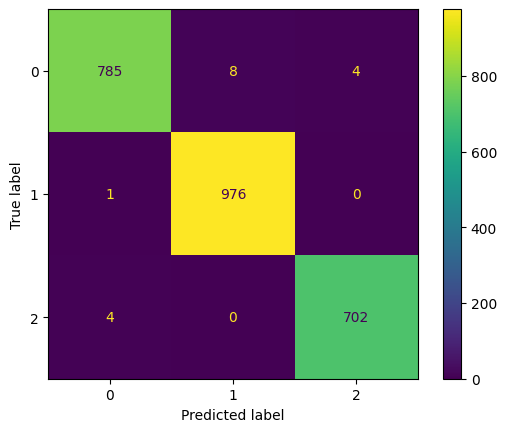

准确率: 0.99


In [56]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 创建随机森林分类器
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# 交叉验证
cv_scores = cross_val_score(rf_clf, X, y, cv=5)
cv_results = cross_validate(rf_clf, X, y, cv=10, scoring='accuracy', return_train_score=False)

# 计算误差（1 - 准确率）
errors = 1 - cv_results['test_score']
print(f"交叉验证准确率: {np.mean(cv_scores):.2f} +/- {np.std(cv_scores):.2f}")
rf_clf.fit(X_train, y_train)
# 在测试集上进行预测
y_pred = rf_clf.predict(X_test)
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
accuracy = accuracy_score(y_test, y_pred)

# 输出准确率
print(f'准确率: {accuracy:.2f}')

c:\Users\74860\kanenv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:51:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\74860\kanenv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:51:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\74860\kanenv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:51:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\74860\kanenv\lib\site-packages\xgboost\core

交叉验证准确率: 0.99 +/- 0.01


c:\Users\74860\kanenv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:51:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


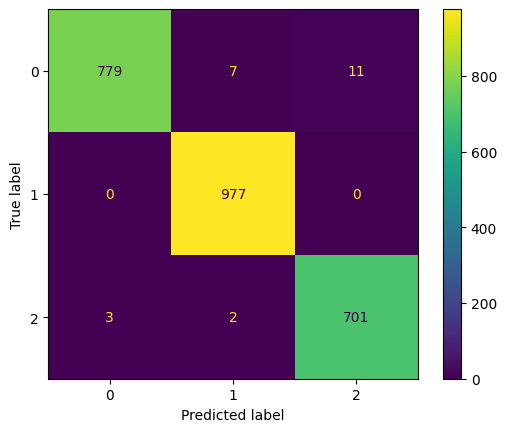

准确率: 0.99


In [57]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建XGBoost分类器，注意这里使用'mlogloss'作为评估指标
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, random_state=42)

# 交叉验证
cv_scores = cross_val_score(xgb_clf, X, y, cv=5)
cv_results = cross_validate(xgb_clf, X, y, cv=10, scoring='accuracy', return_train_score=False)

# 计算误差（1 - 准确率）
errors = 1 - cv_results['test_score']
print(f"交叉验证准确率: {np.mean(cv_scores):.2f} +/- {np.std(cv_scores):.2f}")

# 训练模型
xgb_clf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = xgb_clf.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)

# 输出准确率
print(f'准确率: {accuracy:.2f}')

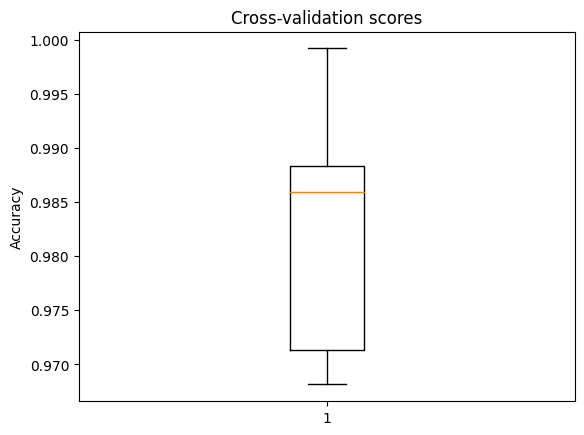

In [50]:
import matplotlib.pyplot as plt

# 假设 cv_scores 是交叉验证得到的得分数组
plt.boxplot(cv_scores)
plt.title('Cross-validation scores')
plt.ylabel('Accuracy')
plt.show()


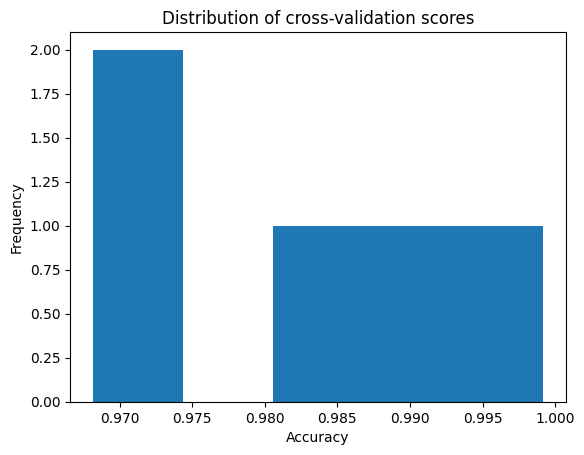

In [51]:
plt.hist(cv_scores, bins=5)
plt.title('Distribution of cross-validation scores')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

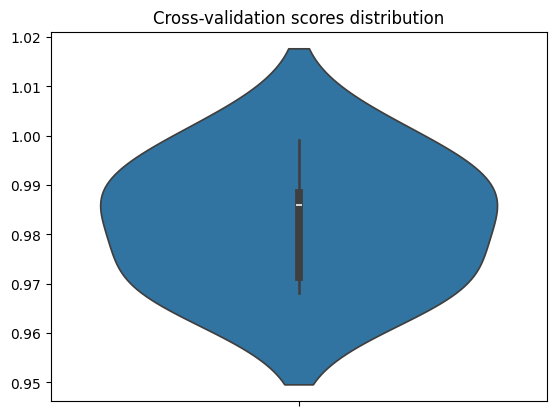

In [52]:
import seaborn as sns

sns.violinplot(data=cv_scores)
plt.title('Cross-validation scores distribution')
plt.show()

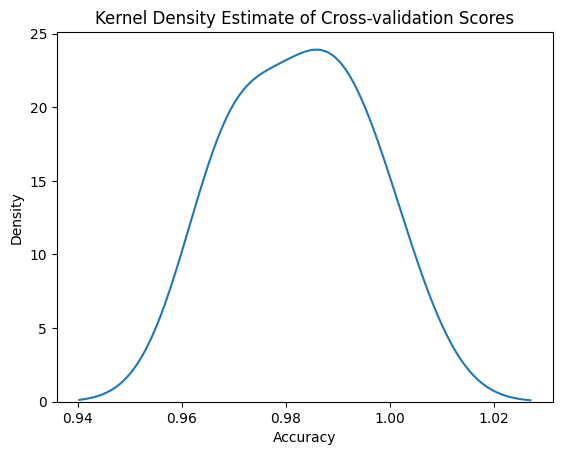

In [53]:
sns.kdeplot(cv_scores)
plt.title('Kernel Density Estimate of Cross-validation Scores')
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.show()

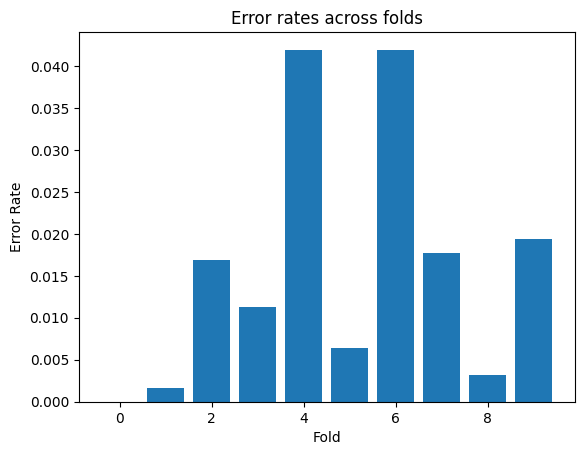

In [54]:
# 假设 errors 是一个包含每次交叉验证误差的数组
errors = 1 - cv_results['test_score']
plt.bar(range(len(errors)), errors)
plt.title('Error rates across folds')
plt.xlabel('Fold')
plt.ylabel('Error Rate')
plt.show()

In [63]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
# 指定文件路径
file_path = '附件二（测试集）.xlsx'

In [68]:
df = pd.read_excel(file_path, sheet_name='测试集')
last_1024_columns = df.iloc[:, -1024:]
# df['B'] = last_1024_columns.max(axis=1)
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统使用SimHei字体
matplotlib.rcParams['font.family']='sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False
waveforms = ['正弦波', '三角波', '梯形波']
sampling_points = 1024
df.columns = df.columns.astype(str)
df
import numpy as np
from sklearn.preprocessing import StandardScaler
x=df.iloc[:,-1024:]
scaler=StandardScaler()
x=scaler.fit_transform(x)
from scipy.fft import fft
feature=pd.DataFrame()
feature['max']=np.max(x,axis=1)
feature['min']=np.min(x,axis=1)
feature['mean']=np.mean(x,axis=1)
feature['std']=np.std(x,axis=1)
feature['fg']=np.max(x,axis=1)-np.min(x,axis=1)
x1=fft(x,axis=1)
sampling_rate=1024
# 计算幅度
magnitude = np.abs(x1)

# 计算功率
power = magnitude ** 2

# 特征提取
features = {}

# 平均幅度
features['mean_magnitude'] = np.mean(magnitude, axis=1)

# 幅度方差
features['variance_magnitude'] = np.var(magnitude, axis=1)

# 平均功率
features['mean_power'] = np.mean(power, axis=1)

# 功率方差
features['variance_power'] = np.var(power, axis=1)

# 峰值幅度
features['peak_magnitude'] = np.max(magnitude, axis=1)

# 峰值频率
peak_indices = np.argmax(magnitude, axis=1)
features['peak_frequency'] = np.array([np.fft.fftfreq(x.shape[1], d=1/sampling_rate)[idx] for idx in peak_indices])

# 能量集中度
energy = power / np.sum(power, axis=1, keepdims=True)
features['energy_focus'] = np.sum(energy, axis=1)

# 中心频率
features['center_frequency'] = np.sum(energy * np.fft.fftfreq(x.shape[1], d=1/sampling_rate), axis=1)

# # 偏度
# features['skewness'] = (np.mean((magnitude - features['mean_magnitude'][:, np.newaxis])**3, axis=1) / (features['variance_magnitude'][:, np.newaxis]**(3/2))).flatten()

# # 峰度
# features['kurtosis'] = (np.mean((magnitude - features['mean_magnitude'][:, np.newaxis])**4, axis=1) / (features['variance_magnitude'][:, np.newaxis]**2) - 3).flatten()

# 总能量
features['total_energy'] = np.sum(power, axis=1)

# 总方差
features['total_variance'] = np.sum((magnitude - features['mean_magnitude'][:, np.newaxis])**2, axis=1)

# features=pd.DataFrame(features)
features=pd.DataFrame(features)
feature=pd.concat([feature,features],axis=1)
feature

,max,min,mean,std,fg,mean_magnitude,variance_magnitude,mean_power,variance_power,peak_magnitude,peak_frequency,energy_focus,center_frequency,total_energy,total_variance
0,2.453005,-1.424633,-0.104683,1.168244,3.877638,3.573859,1395.998041,1408.770512,5.446874e+08,718.289081,1.0,1.0,-6.750156e-12,1.442581e+06,1.429502e+06
1,0.541229,-0.568185,-0.022133,0.369466,1.109414,0.932110,139.414021,140.282850,7.865776e+06,251.706954,1.0,1.0,-6.792777e-11,1.436496e+05,1.427600e+05
2,1.646878,-0.708835,-0.070785,0.641318,2.355713,2.168126,421.589967,426.290737,3.751878e+07,359.534976,1.0,1.0,-2.276601e-11,4.365217e+05,4.317081e+05
3,0.527895,-0.665557,-0.015968,0.448719,1.193452,0.959222,205.522037,206.442145,1.999674e+07,318.221389,1.0,1.0,-4.963940e-11,2.113968e+05,2.104546e+05
4,1.867141,-0.926841,-0.080734,0.792452,2.793981,2.559143,643.177233,649.726445,9.810711e+07,462.711246,1.0,1.0,-1.547973e-11,6.653199e+05,6.586135e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.898667,-0.628812,-0.045994,0.571139,1.527479,1.345402,334.384762,336.194869,4.731866e+07,394.168136,1.0,1.0,-3.960998e-11,3.442635e+05,3.424100e+05
76,0.948857,-0.735724,-0.032081,0.632994,1.684581,1.406236,409.373956,411.351456,7.571524e+07,443.718782,1.0,1.0,-3.053147e-11,4.212239e+05,4.191989e+05
77,1.009148,-1.862246,-0.208579,0.933125,2.871394,2.236750,931.165512,936.168564,3.118668e+08,627.963941,1.0,1.0,-2.817990e-11,9.586366e+05,9.535135e+05
78,0.876287,-0.615686,-0.069273,0.503942,1.491973,1.292220,263.297124,264.966955,2.540156e+07,336.019517,1.0,1.0,-5.301559e-11,2.713262e+05,2.696163e+05


In [73]:
X_test=feature.iloc[:, [0,1,2,3,4,5,7,9,11,13,12,14]]
y_pred = rf_clf.predict(X_test)
pd.DataFrame(y_pred).to_csv('bx.csv')

c:\Users\74860\kanenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
